In [1]:
import os
os.getcwd()
os.chdir('G:\SeatleAirBnbData')

#Imports

#Import linear algebra and data manipulation
import numpy as np
import pandas as pd

#Import plotting packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
#Import machine learning
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split #split
from sklearn.metrics import r2_score, mean_squared_error #metrics

In [2]:
calendar_df = pd.read_csv('../SeatleAirBnbData/calendar.csv')
listing_df = pd.read_csv('../SeatleAirBnbData/listings.csv')

In [3]:
df2 = listing_df.describe(include = ['object']).transpose()
df2

,count,unique,top,freq
listing_url,3818,3818,https://www.airbnb.com/rooms/6133354,1
last_scraped,3818,1,2016-01-04,3818
name,3818,3792,Capitol Hill Apartment,3
summary,3641,3478,This is a modern fully-furnished studio apartm...,15
space,3249,3119,"*Note: This fall, there will be major renovati...",14
...,...,...,...,...
jurisdiction_names,3818,1,WASHINGTON,3818
instant_bookable,3818,2,f,3227
cancellation_policy,3818,3,strict,1417
require_guest_profile_picture,3818,2,f,3497


In [4]:
df3 = df2.loc[df2['unique'] == 1 ] # filtering categorical columns for those with only 1 unique values
only_one_unique= df3.index
listing_df_clean = listing_df.drop(only_one_unique, axis=1)

In [5]:
url_col = []
for col in listing_df.columns:
    if "url" in col: 
        url_col.append(col)
listing_df_clean = listing_df_clean.drop(url_col, axis=1)

In [6]:
listing_df_clean.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,reviews_per_month
count,3.818000e+03,3.818000e+03,3.818000e+03,3816.000000,3816.000000,3818.000000,3818.000000,3818.000000,3802.000000,3812.000000,...,3171.000000,3160.000000,3165.000000,3160.000000,3167.000000,3163.000000,3162.000000,0.0,3818.000000,3191.000000
mean,5.550111e+06,2.016010e+13,1.578556e+07,7.157757,7.157757,47.628961,-122.333103,3.349398,1.259469,1.307712,...,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,NaN,2.946307,2.078919
std,2.962660e+06,0.000000e+00,1.458382e+07,28.628149,28.628149,0.043052,0.031745,1.977599,0.590369,0.883395,...,6.606083,0.698031,0.797274,0.595499,0.568211,0.629053,0.750259,NaN,5.893029,1.822348
min,3.335000e+03,2.016010e+13,4.193000e+03,1.000000,1.000000,47.505088,-122.417219,1.000000,0.000000,0.000000,...,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,NaN,1.000000,0.020000
25%,3.258256e+06,2.016010e+13,3.275204e+06,1.000000,1.000000,47.609418,-122.354320,2.000000,1.000000,1.000000,...,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,NaN,1.000000,0.695000
50%,6.118244e+06,2.016010e+13,1.055814e+07,1.000000,1.000000,47.623601,-122.328874,3.000000,1.000000,1.000000,...,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,1.000000,1.540000
75%,8.035127e+06,2.016010e+13,2.590309e+07,3.000000,3.000000,47.662694,-122.310800,4.000000,1.000000,2.000000,...,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,2.000000,3.000000
max,1.034016e+07,2.016010e+13,5.320861e+07,502.000000,502.000000,47.733358,-122.240607,16.000000,8.000000,7.000000,...,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,37.000000,12.150000


In [7]:
listing_df_clean = listing_df_clean.drop (['name', 'summary', 'space', 'description', 
                        'neighborhood_overview', 'notes', 'transit', 'host_name','calendar_updated'], axis = 1)

In [8]:
listing_df_clean = listing_df_clean.drop (['city','state', 'smart_location'], axis = 1)

In [9]:
listing_df_clean = listing_df_clean.drop (['host_location','host_about', 'host_verifications', 'host_neighbourhood'], axis = 1)

In [10]:
listing_df_clean = listing_df_clean.drop (['neighbourhood','neighbourhood_cleansed', 'zipcode','street'], axis = 1)

In [11]:
listing_df_clean = listing_df_clean.drop (['weekly_price','monthly_price','price'], axis = 1)

In [12]:
boolean_df = ['host_is_superhost','host_has_profile_pic',
                               'host_identity_verified', 'is_location_exact',
                               'instant_bookable','require_guest_profile_picture','require_guest_phone_verification']
listing_df_clean[boolean_df] = listing_df_clean[boolean_df].applymap(lambda x: 1 if x == "t" else 0)

In [14]:
currency_col = ['security_deposit', 'cleaning_fee','extra_people']
for col in currency_col: 
    listing_df_clean[col] = listing_df_clean[col].str.replace("[$,]","").astype(float)

In [15]:
rate_col = ['host_response_rate', 'host_acceptance_rate']
for col in rate_col: 
    listing_df_clean[col] = listing_df_clean[col].str.replace("[%]","").astype(float).apply(lambda x: x/100).fillna(0)

In [16]:
time_col = ['host_since','first_review','last_review']
basedate = pd.Timestamp('2016-01-04')
for col in time_col:
    listing_df_clean[col] = pd.to_datetime(listing_df_clean[col] , format = "%Y-%m-%d").apply(lambda x : (basedate-x).days).fillna(0)

In [17]:
def get_val_from_list(row, column_name, value):
    ''' Fill in dummy column for values '''
    val = 0.0
    try:
        vals = row[column_name].replace('[', '').replace("'", '').replace("]", '').replace('"', '').replace('{', '').replace('}', '').split(',')
        if value in vals:
            val = 1.0
    except:
        val = 0.0
    return val

values_dict = {}
for unique_value in listing_df_clean['amenities'].unique(): 
    for value in unique_value.replace('[', '').replace("'", '').replace("]", '').replace('"', '').replace('{', '').replace('}', '').split(','):
        if value in values_dict:
              values_dict[value] = values_dict[value] + 1
        else:
              values_dict[value] = 0
              
values_sorted = sorted(values_dict.items(), key=lambda kv: kv[1], reverse = True)
    
    #split into columns
for value in values_sorted[: 10]:
      listing_df_clean['amenities' + '_' + value[0]] = listing_df_clean.apply(lambda row: get_val_from_list(row, 'amenities', value[0]),axis=1)
#drop original column
listing_df_clean = listing_df_clean.drop('amenities', axis = 1)

In [18]:
cat_df = listing_df_clean.select_dtypes(include = 'object')
cat_cols_lst = cat_df.columns
for col in cat_cols_lst:
    listing_df_clean = pd.concat([listing_df_clean.drop(col, axis = 1), pd.get_dummies(listing_df_clean[col]
                                                                                                , prefix = col, prefix_sep = "_", dummy_na = True)], axis = 1)

In [19]:
listing_df_clean = listing_df_clean.drop(['square_feet', 'license','scrape_id', 'host_id'], axis = 1)

In [20]:
listing_df_clean = listing_df_clean.fillna(listing_df_clean.median())

In [21]:
calendar_df_clean = calendar_df.drop('available', axis = 1)
calendar_df_clean['date'] = pd.to_datetime(calendar_df_clean['date'] , format = "%Y-%m-%d").dt.month.astype(str)
calendar_df_clean['price'] = calendar_df_clean['price'].str.replace("[$,]","").astype(float)
calendar_df_clean = calendar_df_clean.rename(columns = {'date': "month", 'price':'listing_price'})
calendar_df_clean = calendar_df_clean.dropna(axis=0)
calendar_df_clean= pd.concat([calendar_df_clean.drop('month', axis =1), pd.get_dummies(calendar_df_clean['month'], prefix ='month')], axis = 1)


In [22]:
calendar_df_clean

,listing_id,listing_price,month_1,month_10,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9
0,241032,85.0,1,0,0,0,0,0,0,0,0,0,0,0
1,241032,85.0,1,0,0,0,0,0,0,0,0,0,0,0
9,241032,85.0,1,0,0,0,0,0,0,0,0,0,0,0
10,241032,85.0,1,0,0,0,0,0,0,0,0,0,0,0
14,241032,85.0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1393207,10208623,87.0,1,0,0,0,0,0,0,0,0,0,0,0
1393208,10208623,87.0,1,0,0,0,0,0,0,0,0,0,0,0
1393211,10208623,87.0,1,0,0,0,0,0,0,0,0,0,0,0
1393212,10208623,87.0,1,0,0,0,0,0,0,0,0,0,0,0


In [23]:
final_df = pd.merge (calendar_df_clean, listing_df_clean, how = 'left', left_on = 'listing_id', right_on = 'id' )

In [24]:
final_df

,listing_id,listing_price,month_1,month_10,month_11,month_12,month_2,month_3,month_4,month_5,...,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,bed_type_nan,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_nan
0,241032,85.0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1,241032,85.0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,241032,85.0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
3,241032,85.0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,241032,85.0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
934537,10208623,87.0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
934538,10208623,87.0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
934539,10208623,87.0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
934540,10208623,87.0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0


In [25]:
test_size = 0.3
random_seed = 42

X = final_df.drop('listing_price', axis = 1)
y = final_df['listing_price']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = test_size, random_state = random_seed)

In [26]:
#train RF regressor model
forest = RandomForestRegressor(n_estimators=100, 
                               criterion='mse', 
                               random_state=random_seed, 
                               n_jobs=-1)
forest.fit(X_train, y_train.squeeze())

#calculate scores for the model
y_train_preds = forest.predict(X_train)
y_test_preds = forest.predict(X_test)

print('Random Forest MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_preds),
        mean_squared_error(y_test, y_test_preds)))
print('Random Forest R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_preds),
        r2_score(y_test, y_test_preds)))

Random Forest MSE train: 186.469, test: 210.519
Random Forest R^2 train: 0.983, test: 0.981


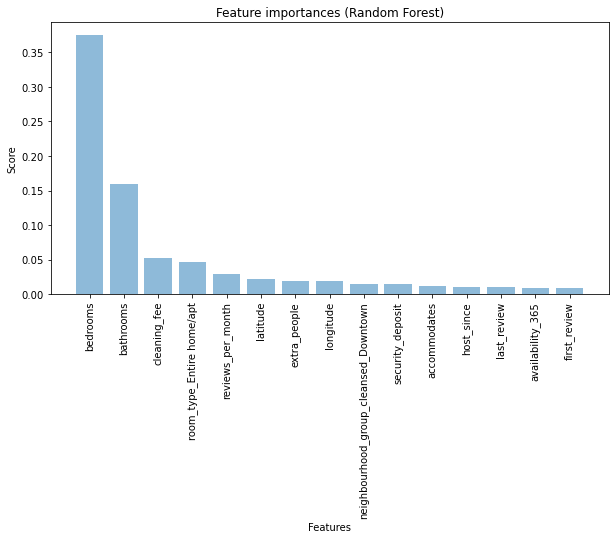

In [27]:
#get feature importances from the model
headers = ["name", "score"]
values = sorted(zip(X_train.columns, forest.feature_importances_), key=lambda x: x[1] * -1)
forest_feature_importances = pd.DataFrame(values, columns = headers)
forest_feature_importances = forest_feature_importances.sort_values(by = ['score'], ascending = False)

features = forest_feature_importances['name'][:15]
y_pos = np.arange(len(features))
scores = forest_feature_importances['score'][:15]

#plot feature importances
plt.figure(figsize=(10,5))
plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, features, rotation='vertical')
plt.ylabel('Score')
plt.xlabel('Features')
plt.title('Feature importances (Random Forest)')

plt.savefig('feature importances RF.png')
 
plt.show()